In [2]:
import pandas as pd

In [3]:
dl_df = pd.read_csv("/content/dl_wfo_predictions.csv")

In [6]:
arima_df = pd.read_csv("/content/arima_wfo_predictions.csv")
arima_df.head()


,actual,arima_pred
0,0.013899,-0.001260
1,0.001902,0.001962
2,-0.005239,0.001019
3,0.037033,0.000298
4,-0.002304,0.004223


In [7]:
import os

print(os.path.exists("/content/arima_wfo_predictions.csv"))
print(os.path.exists("/content/ml_wfo_predictions.csv"))
print(os.path.exists("/content/dl_wfo_predictions.csv"))


True
True
True


In [9]:
ml_df = pd.read_csv("/content/ml_wfo_predictions.csv")
ml_df.head()

,actual,ml_pred
0,0.046080,-0.000840
1,-0.010447,-0.004300
2,0.003495,0.001371
3,0.004640,0.002049
4,0.017212,-0.010317


In [10]:
dl_df = pd.read_csv("/content/dl_wfo_predictions.csv")
dl_df.head()

,actual,dl_pred
0,0.035932,0.000414
1,0.038176,0.002184
2,0.035512,0.003187
3,-0.020383,0.002416
4,-0.007752,-0.002397


In [11]:
min_len = min(len(arima_df), len(ml_df), len(dl_df))

df_ens = pd.DataFrame({
    "actual": arima_df["actual"].values[-min_len:],
    "arima":  arima_df["arima_pred"].values[-min_len:],
    "rf":     ml_df["ml_pred"].values[-min_len:],
    "lstm":   dl_df["dl_pred"].values[-min_len:]
})

In [12]:
df_ens.shape
df_ens.head()


,actual,arima,rf,lstm
0,0.035932,-0.000768,0.001655,0.000414
1,0.038176,0.004059,0.000099,0.002184
2,0.035512,0.004592,-0.002993,0.003187
3,-0.020383,0.004430,-0.002398,0.002416
4,-0.007752,-0.000841,0.001245,-0.002397


In [17]:
rmse_arima = np.sqrt(mean_squared_error(df_ens["actual"], df_ens["arima"]))
rmse_rf    = np.sqrt(mean_squared_error(df_ens["actual"], df_ens["rf"]))
rmse_lstm  = np.sqrt(mean_squared_error(df_ens["actual"], df_ens["lstm"]))

rmse_arima, rmse_rf, rmse_lstm


(np.float64(0.04069348489147978),
 np.float64(0.04112465496413814),
 np.float64(0.041374305548605106))

In [16]:
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np


In [18]:
df_ens["ensemble_manual"] = (
    0.30 * df_ens["arima"] +
    0.35 * df_ens["rf"] +
    0.35 * df_ens["lstm"]
)

In [19]:
rmse_manual = np.sqrt(
    mean_squared_error(df_ens["actual"], df_ens["ensemble_manual"])
)

rmse_manual

np.float64(0.040819320528469975)

In [22]:
X_stack = df_ens[["arima", "rf", "lstm"]]
y_true  = df_ens["actual"]

meta = LinearRegression(fit_intercept=False)
meta.fit(X_stack, y_true)

weights = meta.coef_
weights


array([ 0.26633961, -0.34595953,  0.18254555])

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


In [23]:
df_ens["ensemble_stacked"] = meta.predict(X_stack)

rmse_stacked = np.sqrt(
    mean_squared_error(y_true, df_ens["ensemble_stacked"])
)

rmse_stacked

np.float64(0.04056078576775486)

In [24]:
pd.DataFrame({
    "Model": [
        "ARIMA",
        "Random Forest",
        "LSTM",
        "Manual Ensemble",
        "Stacked Ensemble"
    ],
    "RMSE": [
        rmse_arima,
        rmse_rf,
        rmse_lstm,
        rmse_manual,
        rmse_stacked
    ]
})


,Model,RMSE
0,ARIMA,0.040693
1,Random Forest,0.041125
2,LSTM,0.041374
3,Manual Ensemble,0.040819
4,Stacked Ensemble,0.040561


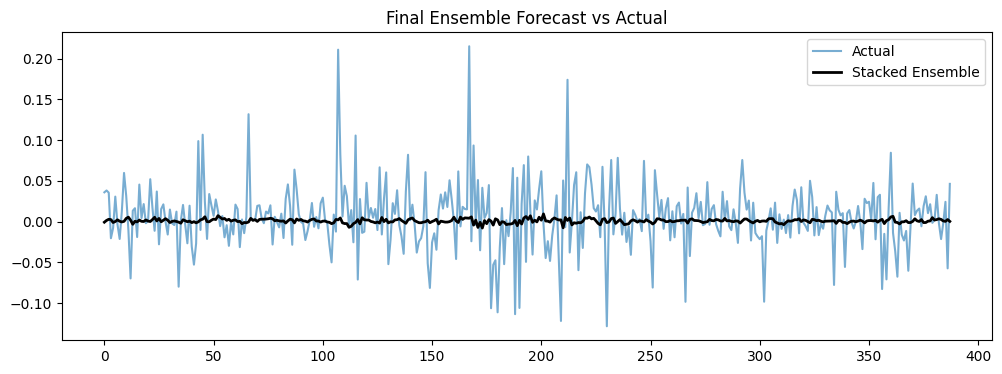

In [25]:
plt.figure(figsize=(12,4))
plt.plot(df_ens["actual"].values, label="Actual", alpha=0.6)
plt.plot(df_ens["ensemble_stacked"].values, label="Stacked Ensemble", color="black", linewidth=2)
plt.legend()
plt.title("Final Ensemble Forecast vs Actual")
plt.show()


In [26]:
df_ens.to_csv("/content/final_ensemble_results.csv", index=False)